## Prepare

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download prajitdatta/ultimate-25k-matches-football-database-european
! unzip ultimate-25k-matches-football-database-european

 92% 30.0M/32.7M [00:01<00:00, 40.4MB/s]
100% 32.7M/32.7M [00:01<00:00, 33.6MB/s]
Archive:  ultimate-25k-matches-football-database-european.zip
  inflating: database.sqlite         


In [ ]:
import sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
import statistics
import matplotlib.pyplot as plt

In [ ]:
from scipy.stats import poisson
from scipy.stats import pearsonr
from scipy.stats import norm
from scipy.stats import expon
import scipy.stats as stats

In [ ]:
from random import choices

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
import numpy.random as rd
from scipy.stats import pareto

from pathlib import Path
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

import os
import imageio

In [ ]:
connection = sqlite3.connect('database.sqlite')
cursor = connection.cursor()

## Functions

In [ ]:
def turn_to_seasons(year):
  return str(year)+"/"+str(year+1), str(year+1)+"/"+str(year+2)

In [ ]:
def scaleodds(odds):
  virtual = 1/odds[0] + 1/odds[1] + 1/odds[2]
  return (
      virtual * odds[0],
      virtual * odds[1],
      virtual * odds[2]
  )

In [ ]:
def result(goals):
  winH = goals[0] > goals[1]
  draw = goals[0] == goals[1]
  winA = goals[0] < goals[1]
  return draw*1 + winA*2

In [ ]:
def aggregate_goals(df, teams):
  goals_scored_means = []
  goals_recieved_means = []

  for team in teams:
    gsh = df[df['home_team_api_id'] == team]['home_team_goal'].mean()
    gsa = df[df['away_team_api_id'] == team]['away_team_goal'].mean()
    goals_scored_means.append((gsh+gsa)/2)

    grh = df[df['home_team_api_id'] == team]['away_team_goal'].mean()
    gra = df[df['away_team_api_id'] == team]['home_team_goal'].mean()
    goals_recieved_means.append((grh+gra)/2)
  return goals_scored_means, goals_recieved_means

In [ ]:
def aggregate_goals_weighted(dfs, teams):
  goals_scored = np.zeros(len(teams))
  goals_recieved = np.zeros(len(teams))

  weight_season = 1

  for df in dfs:
    gs, gr = aggregate_goals(df, teams)
    goals_scored += np.array(gs) * weight_season
    goals_recieved += np.array(gr) * weight_season
    weight_season *= 2

  goals_scored /= weight_season-1
  goals_recieved /= weight_season-1

  return goals_scored, goals_recieved

###fff

In [ ]:
def wins(bets, df):

  return (df["scaledH"] * ((bets == "H") & (df["result"] == 0)) + \
          df["scaledD"] * ((bets == "D") & (df["result"] == 1)) + \
          df["scaledA"] * ((bets == "A") & (df["result"] == 2))).sum() / \
          (bets != "-1").sum(), (bets != "-1").sum()

In [ ]:
def confidence(home_team, away_team, c, c_bad, df_teams):
  x = probs_to_odds(home_team, away_team, c, df_teams)
  y = probs_to_odds_bad(home_team, away_team, c_bad, df_teams)
  ratio = [x[i]/y[i] for i in range(3)]

  return ratio[1], ratio[0] - ratio[2]

In [ ]:
def remove_not_in_teams(df, teams):
  df = df[df['home_team_api_id'].isin(teams) & df['away_team_api_id'].isin(teams)]
  return df

In [ ]:
def decision4(sign):
  dec = np.zeros(sign.shape)
  dec = dec.astype(str)
  dec[sign > 0] = "A"
  dec[sign < 0] = "H"
  return dec

### Fs testing

In [ ]:
def expected_returns0(w, expected_gama):
  new_mius = []
  likelyhood_fs = []

  for wei in w:
    gama = np.linspace(0,0.2,1001)
    def pdf(x, y=wei):
      return norm.pdf(y, loc=x+1, scale=std) * expon.pdf(x, scale=expected_gama)

    pdf_gama = pdf(gama)

    pdf_gama /= pdf_gama.mean()

    new_mius.append(np.mean(pdf_gama * gama))

    likelyhood_fs.append(pdf_gama)

  return new_mius, likelyhood_fs

In [ ]:
def expected_returns(x, likelyhood_fs):
  new_mius = []
  likelyhood_fs2 = []

  for i in range(x.size):
    gama = np.linspace(0,0.2,1001)
    def pdf(x, y=x[i]):
      return norm.pdf(y, loc=x+1, scale=std) * likelyhood_fs[i][np.floor(x*1000/0.2).astype(int)]

    pdf_gama = pdf(gama)

    pdf_gama /= pdf_gama.mean()

    new_mius.append(np.mean(pdf_gama * gama))

    likelyhood_fs2.append(pdf_gama)

  return new_mius, likelyhood_fs2


In [ ]:
def combine(u1, u2, v1, v2):
  def to_maximize(x):
    return (x*x*u1*u1+(1-x)*(1-x)*u2*u2+(1-x)*x*u1*u2)/(x*x*v1+(1-x)*(1-x)*v2)
  weightings_returns = []
  xses = np.linspace(0.0, 1.0, 1001)
  for x in xses:
    weightings_returns.append(to_maximize(x))
  w1 = xses[np.array(weightings_returns).argmax()]
  w2 = 1 - w1
  miu_new = w1 * u1 + w2 * u2
  var_new = w1*w1 * v1 + w2*w2 * v2
  return miu_new, var_new, w2/w1

In [ ]:
def get_weights(new_mius, std):
  weights = [1 for i in range(len(new_mius))]
  p_miu, p_var = new_mius[0], std*std
  scale = 1

  for i in range(1,len(new_mius)):
    p_miu, p_var, rat = combine(p_miu, new_mius[i], p_var, std*std)
    weights[i] = rat * scale
    scale += weights[i]

  return weights

In [ ]:
def profit(weights, wins):
  return (weights * wins).sum() / weights.sum()

In [ ]:
def f(x, goals_pred):
  return 1 / (np.power(x-goals_pred, 2) + 0.01)

In [ ]:
def compute_feat_avg(home_team, df_teams, feature):
  try:
    return df_teams[df_teams['team'] == home_team][feature].iloc[0]
  except:
    print(home_team)
    return None

In [ ]:
def compute_pos_2(away_team, df_teams):
  return df_teams[df_teams['team'] == away_team]["possession"].iloc[0]

In [ ]:
def compute_x1(home_team, df_teams):
  return df_teams[df_teams['team'] == home_team]["goals_scored"].iloc[0]

In [ ]:
def compute_x2(away_team, df_teams):
  return df_teams[df_teams['team'] == away_team]["goals_scored"].iloc[0]

In [ ]:
def compute_x3(home_team, df_teams):
  return df_teams[df_teams['team'] == home_team]["goals_recieved"].iloc[0]

In [ ]:
def compute_x4(away_team, df_teams):
  return df_teams[df_teams['team'] == away_team]["goals_recieved"].iloc[0]

In [ ]:
comp_p = []
for x in np.linspace(0, 20, 20001):
  for_n_goals = []
  for k in range(10):
    for_n_goals.append(poisson.pmf(k, x))
  comp_p.append(for_n_goals)

In [ ]:
def f(x, goals_pred, c):
  return norm.pdf(x, loc=goals_pred, scale=c)



In [ ]:
def precomp_p(k, x):
  return comp_p[min([np.floor(x*1000).astype(int),20000])][k]

## EDA

In [ ]:
df = pd.read_sql_query("SELECT home_team_api_id, \
                           away_team_api_id, \
                           possession, \
                           home_team_goal, \
                           away_team_goal \
                           FROM Match \
                           WHERE possession IS NOT NULL", connection)

In [ ]:
def extract_pos(s:str):
  try:
    i = s.index('<homepos>')
  except:
    return -1
  l = len('<homepos>')
  return int(s[i+l:i+l+2])

In [ ]:
teams_bad = [9873,
             8398,
             2183,
             8673,
             1601,
             8021,
             1957,
             2182]

In [ ]:
df = df[~(df['away_team_api_id'].isin(teams_bad) | df['away_team_api_id'].isin(teams_bad))]

In [ ]:
df["home_pos"] = df["possession"].apply(extract_pos)

In [ ]:
df = df[df["home_pos"] != -1]

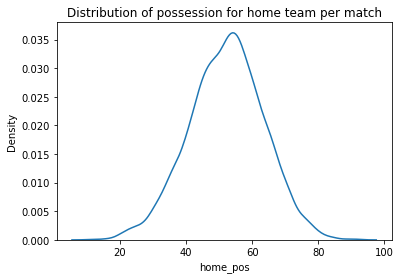

In [ ]:
sns.kdeplot(df["home_pos"]).set(title="Distribution of possession for home team per match");

In [ ]:
teams = df['home_team_api_id'].unique()
df_teams = pd.DataFrame({"team":teams})
df_teams["goals_scored"], df_teams["goals_recieved"] = aggregate_goals(df, teams)

In [ ]:
p_team = []

for team in teams:
  ph = df[df['home_team_api_id'] == team]['home_pos'].mean()
  pa = df[df['away_team_api_id'] == team]['home_pos'].mean()
  p_team.append((ph+100-pa)/2)

In [ ]:
p_team_stdev = []

for team in teams:
  ph = df[df['home_team_api_id'] == team]['home_pos']
  pa = df[df['away_team_api_id'] == team]['home_pos']
  p_team_stdev.append(pd.concat([ph,100-pa]).std())

In [ ]:
df_teams["possession"] = p_team

In [ ]:
df_teams["pos_std"] = p_team_stdev

In [ ]:
def plot_pearson(df, x_feature, y_feature, single_tail=False, title=None):
  df = df[df[x_feature].notna() & df[y_feature].notna()]
  r, p = stats.pearsonr(df[x_feature],df[y_feature])
  if single_tail:
    p = p / 2
  plt.figure()
  ax = sns.regplot(x=df[x_feature], y=df[y_feature],
              scatter_kws={'s':2},
              line_kws={'label':"r={0:.2f}\np={1:.2f}".format(r,p)}
              )
  ax.legend();
  ax.set(title=title);

In [ ]:
lam = df["home_team_goal"].mean()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of goals (blue) vs poisson distribution (orange)')]

([<matplotlib.axis.XTick at 0x7f570978cb90>,
 <a list of 9 Text major ticklabel objects>)

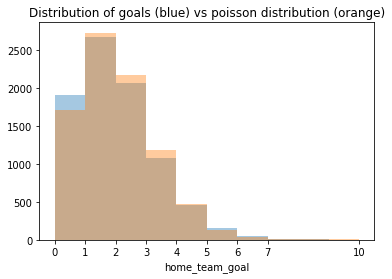

In [ ]:
arr = df["home_team_goal"]
sns.distplot(arr, bins = arr.sort_values(), kde = False).set(title="Distribution of goals (blue) vs poisson distribution (orange)");

arr = pd.Series(np.random.poisson(lam, df.shape[0]))
sns.distplot(arr, bins = arr.sort_values(), kde = False);

plt.xticks(arr.unique());
plt.show()

In [ ]:
df["result"] = result([df['home_team_goal'], df['away_team_goal']])

In [ ]:
wins_home = df[df["result"] == 0].shape[0]
wins_away = df[df["result"] == 2].shape[0]
draw = df[df["result"] == 1].shape[0]

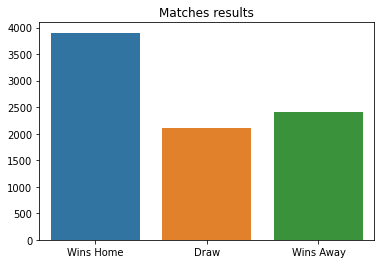

In [ ]:
sns.barplot(x=["Wins Home", "Draw", "Wins Away"], y=[wins_home, draw, wins_away]).set(title="Matches results");

## Possession and goals scored

In [ ]:
df["pos_home_avg"] = df.apply(lambda x: compute_feat_avg(x.home_team_api_id, df_teams, "possession"), axis=1)
df["gs_home_avg"] = df.apply(lambda x: compute_feat_avg(x.home_team_api_id, df_teams, "goals_scored"), axis=1)
df["gr_home_avg"] = df.apply(lambda x: compute_feat_avg(x.home_team_api_id, df_teams, "goals_recieved"), axis=1)
df["pos_away_avg"] = df.apply(lambda x: compute_feat_avg(x.away_team_api_id, df_teams, "possession"), axis=1)
df["gs_away_avg"] = df.apply(lambda x: compute_feat_avg(x.away_team_api_id, df_teams, "goals_scored"), axis=1)
df["gr_away_avg"] = df.apply(lambda x: compute_feat_avg(x.away_team_api_id, df_teams, "goals_recieved"), axis=1)

In [ ]:
df = df[df["pos_home_avg"].notna()]
df = df[df["gs_home_avg"].notna()]
df = df[df["gr_home_avg"].notna()]

In [ ]:
X = np.array([df["home_pos"]])
y = np.array(df['home_team_goal'])
X = X.T
reg = LinearRegression().fit(X, y)

print(reg.coef_)
print(reg.intercept_)

emp_g_per_p = reg.coef_[0]

[0.02673302]
0.1732616586307163


In [ ]:
X = np.array([df["home_pos"],
              df["pos_home_avg"],
              df["pos_away_avg"]
              ])
y = np.array(df['home_team_goal'])
X = X.T
reg = LinearRegression().fit(X, y)

print(reg.coef_)
print(reg.intercept_)

c_emp_g_per_p = reg.coef_[0]

[ 0.00367572  0.06727109 -0.03504261]
-0.2369573786732202


In [ ]:
exp_g_per_p = df['home_team_goal'].mean() / 100

Next, I will explore the relationship between goals scored and possession.

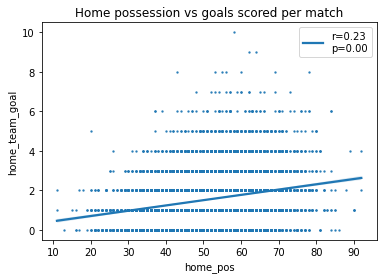

In [ ]:
plot_pearson(df, "home_pos", "home_team_goal",
             title="Home possession vs goals scored per match")

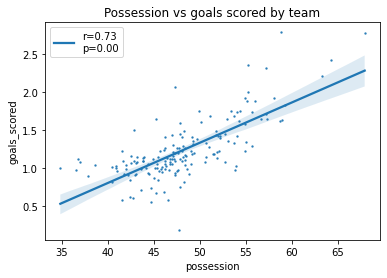

In [ ]:
plot_pearson(df_teams, "possession", "goals_scored",
             title="Possession vs goals scored by team")

The correlation between goals scored and possession at the level of match is much smaller than the global correlation (teams).

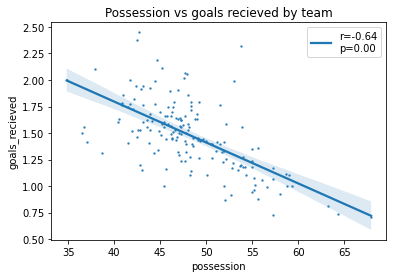

In [ ]:
plot_pearson(df_teams, "possession", "goals_recieved",
             title="Possession vs goals recieved by team")

In a similar way, goals recieved are anti-correlated with possession.

<h3> Explanations:



In light of these facts there are two ways to explain the correlation between goals scored and possession:
* **direct:** holding the ball more gives a team more chances to score.
* **indirect:** possession is a good proxy for a skilled team, and also depends on the shape they are in.

* blue circles can be measured
* red circles can't be directly measured

![picture](https://drive.google.com/uc?export=view&id=1nHPioBVbMJZPdr9NnqK9-Qiki8YJnKKm)

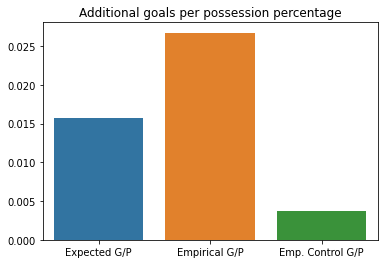

In [ ]:
x = ["Expected G/P", "Empirical G/P", "Emp. Control G/P"]
y = [exp_g_per_p, emp_g_per_p, c_emp_g_per_p]
sns.barplot(x=x, y=y).set(title="Additional goals per possession percentage");

Theory(blue): every minute a team holds the ball is an oportunity for scoring
<br>
Observed(orange): no controls
<br>
Observed(green): Controls: Overall possession in all matches for home and away

It may be that possession is just a proxy for team ability. What really matters is whether you advance the ball into opponent's territory. Teams and analysts may be overestimating the importance of possession.

## Offensive vs Defensive Teams

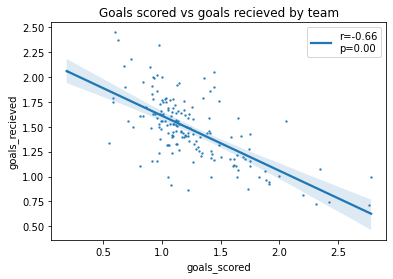

In [ ]:
plot_pearson(df_teams, "goals_scored", "goals_recieved",
             title="Goals scored vs goals recieved by team")

We see there is an anti-correlation between goals recieved and goals scored by team. This could be interpreted as "teams vary more in terms of good vs. bad rather than offensive vs. defensive".
<br>
One explanation for this is that teams try to stay balanced. However, a different cause could be the inequality between teams in terms of wealth. Given that wealth is distributed on a pareto distribution, a quite unequal one, a correlation between the defensive and offensive strenght will appear even if many teams use unbalanced strategies.
<br>
Even if a rich team plans to be offensive, they will still put more money into defence than a poor team that try to be defensive.

### Pareto distribution

#### Make gif

In [ ]:
x = np.linspace(0, 10 , 1001)
b = 1.16

In [ ]:
y = pareto.pdf(x, b, loc=-1)

In [ ]:
plt.stackplot(x, y, alpha=0.5)
plt.savefig('images/only1dist.png')
plt.close()

In [ ]:
plt.stackplot(x, y, alpha=0.5)
plt.stackplot(x[x>=1], y[x>=1], alpha=1)
plt.savefig('images/cut.png')
plt.close()

In [ ]:
steps = [10,10,20,10,5]

In [ ]:
alpha = (y[x<=9] - y[x>=1]) / steps[2]

for i in range(steps[2]):
  y_prime = y[x>=1] + alpha*(i+1)
  plt.stackplot(x, y, alpha=0.5)
  plt.stackplot(x[x>=1], y_prime, alpha=1)
  plt.savefig(f'images/scale{i}.png')
  plt.close()

In [ ]:
beta = 1 / steps[3]

for i in range(steps[3]):
  x_prime = x[x>=1] - beta*(i+1)
  plt.stackplot(x, y, alpha=0.5)
  plt.stackplot(x_prime, y_prime, alpha=1)
  plt.savefig(f'images/translate{i}.png')
  plt.close()

In [ ]:
gif_name = 'pareto_gif.gif'



with imageio.get_writer(gif_name, mode='I') as writer:
  for _ in range(steps[0]):
    filename = "images/only1dist.png"
    image = imageio.imread(filename)
    writer.append_data(image)

  for _ in range(steps[1]):
    filename = "images/cut.png"
    image = imageio.imread(filename)
    writer.append_data(image)

  for filename in [f'images/scale{i}.png' for i in range(steps[2])]:
    image = imageio.imread(filename)
    writer.append_data(image)

  for filename in [f'images/translate{i}.png' for i in range(steps[3])]:
    image = imageio.imread(filename)
    writer.append_data(image)

  for _ in range(steps[1]):
    filename = "images/translate9.png"
    image = imageio.imread(filename)
    writer.append_data(image)

gif = imageio.mimread(gif_name)

imageio.mimsave(gif_name, gif, fps=10)

#### Gif

Even if there is selection bias (only the best teams from a country are featured in this dataset), wealth can still be modeled by a pareto distribution.
<br>
Pareto distribution, being a power law, remains a pareto distribution after taking in consideration only points above a threshold, as seen in the animation below.

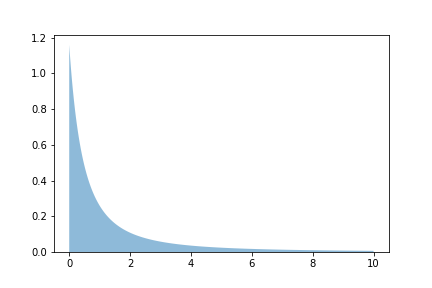

In [ ]:
gifPath = Path(f"pareto_gif.gif")
with open(gifPath,'rb') as f:
  display.Image(data=f.read(), format='png')

## Pymc3 bayesian modeling

In [ ]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 4.2 MB/s 
     |████████████████████████████████| 1.8 MB 38.9 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=319d8e35582f107c67144159f2165d7fd54d3d8462723056430c8716276bacf0
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built theano-pymc


In [ ]:
import pymc3 as pm

In [ ]:
with pm.Model() as model:
  alpha = pm.math.constant(1.16)
  m = pm.Exponential("m", 1, shape=1)
  wealth = pm.Pareto("wealth", alpha=alpha, m=m[0])

  BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=1.0)
  mu = pm.math.constant(0.5)
  sigma_f = BoundedNormal("sigma_f", mu=0.3, sigma=0.6, shape=1)
  fraction = BoundedNormal("fraction", mu=mu, sigma=sigma_f)   #, sigma=sigma_f[0])

  investment_def = pm.Deterministic("investment_def", wealth*fraction)
  investment_at = pm.Deterministic("investment_at", wealth*(1-fraction))

  c1 = pm.Exponential("c1", 1)
  c3 = pm.Exponential("c3", 1)

  c2 = pm.Normal("c2", mu=-2, sigma=2)
  c4 = pm.Normal("c4", mu=2, sigma=2)

  sigma1 = pm.HalfNormal("sigma1", sigma=2)
  sigma2 = pm.HalfNormal("sigma2", sigma=2)

  defence = pm.Normal("defence", mu=np.log(investment_def)*c1+c2, sigma=sigma1)
  atack = pm.Normal("atack", mu=np.log(investment_at)*c3+c4, sigma=sigma2)

  sigma_a = pm.math.constant(0.02)

  def_observed = pm.Normal("def_observed", mu=defence, sigma=sigma_a, observed=-df_teams["goals_recieved"])
  at_observed = pm.Normal("at_observed", mu=atack, sigma=sigma_a, observed=df_teams["goals_scored"])

  trace = pm.sample(3000, cores=4, target_accept=0.98)

/usr/local/lib/python3.7/dist-packages/pymc3/model.py:1755: ImputationWarning: Data in def_observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/usr/local/lib/python3.7/dist-packages/pymc3/model.py:1755: ImputationWarning: Data in at_observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/usr/local/lib/python3.7/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


ERROR:pymc3:There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 55 divergences after tuning. Increase `target_accept` or reparameterize.


<Figure size 504x504 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56d7060510>,
      dtype=object)

<Figure size 504x504 with 0 Axes>

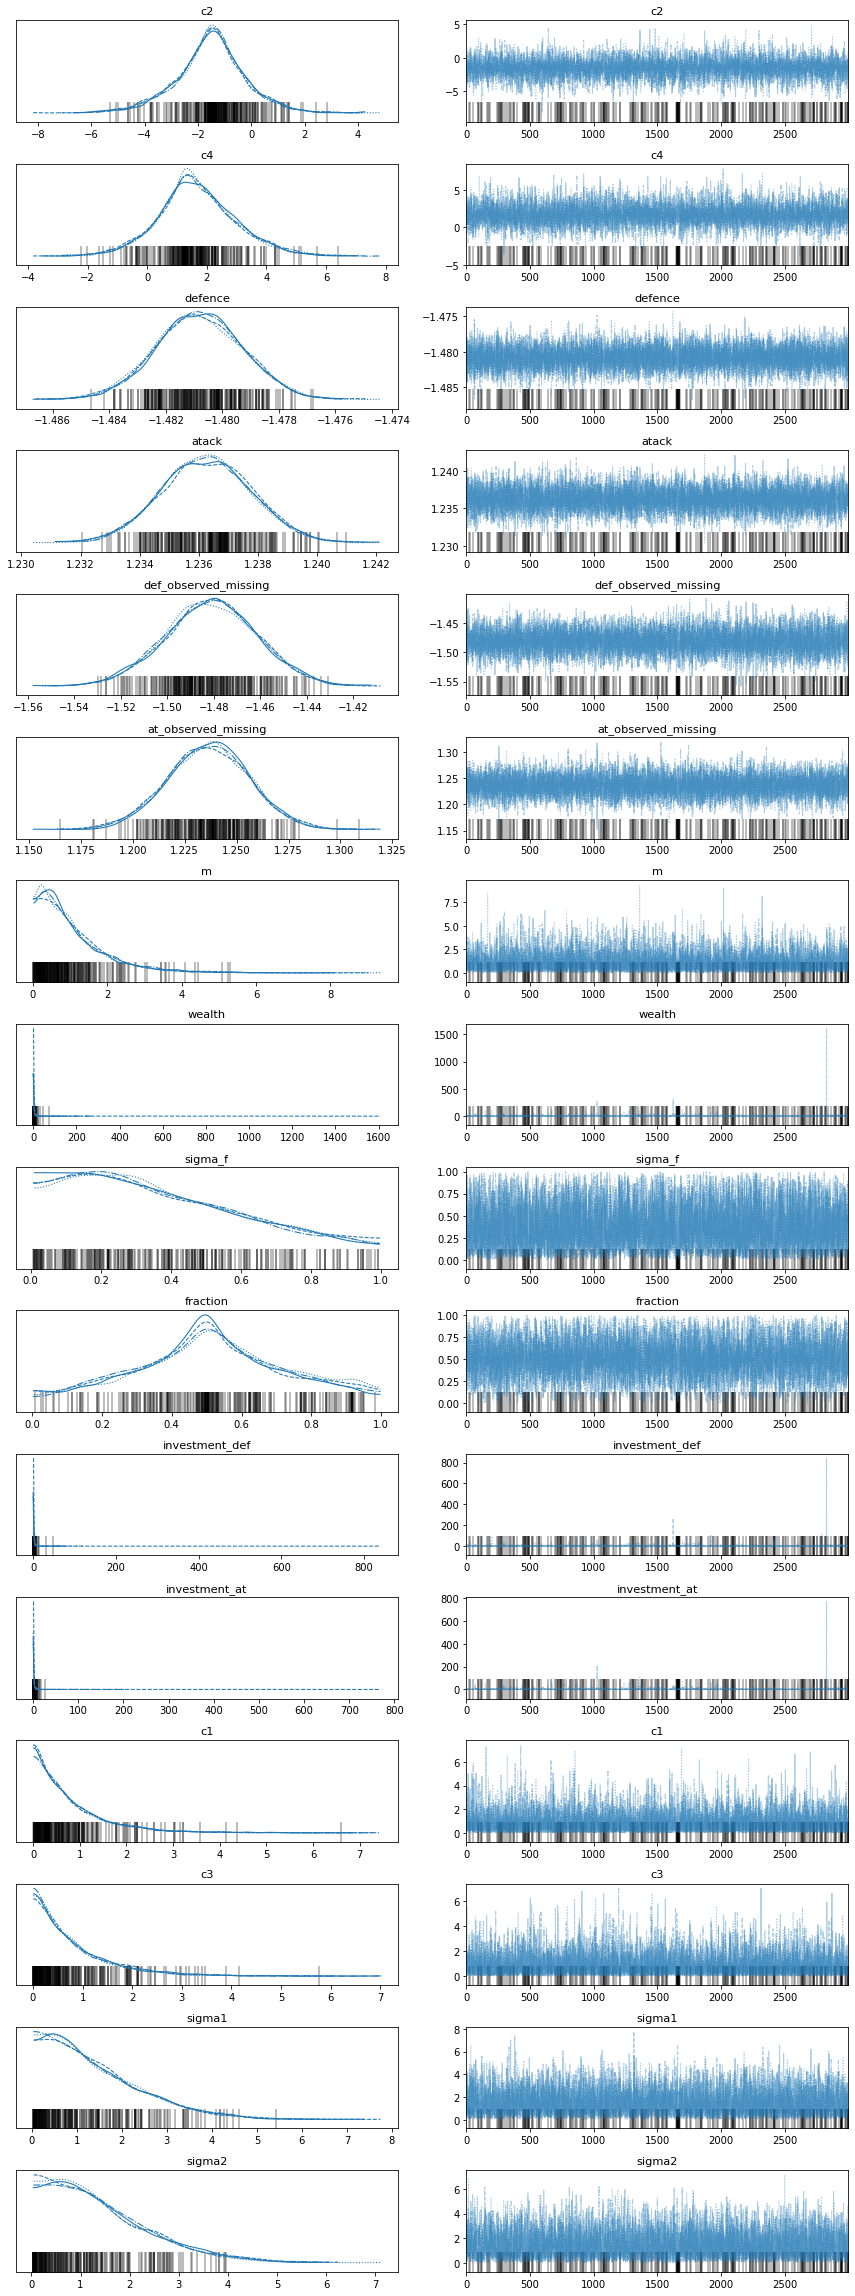

In [ ]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()

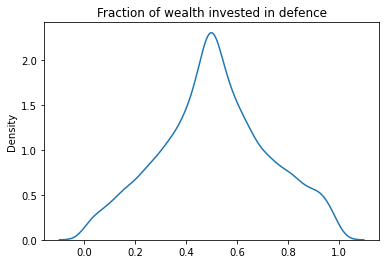

In [ ]:
fraction1 = trace.get_values("fraction")
sns.kdeplot(fraction1).set(title="Fraction of wealth invested in defence");

While there are many teams that try to stay balanced, there is also a non-neglijable number of teams that invest more than 80% in their attack or defence.

## Countries and Years

In [ ]:
countries = [1729, 4769, 7809, 10257, 13274, 17642, 19694, 21518]

In [ ]:
years = range(2008, 2016)

In [ ]:
countries_names = ["England",
                   "France",
                   "Germany",
                   "Italy",
                   "Netherlands",
                   "Portugal",
                   "Scotland",
                   "Spain"]

## Models

<h2> Model Design:

From my research into what other people who try to bet on football using data science methods, they usually try to estimate the probability of each possible outcome, compare it with the odds offered by the bookkeepers and bet accordingly.
<br>
However, this method ignores the advantage you get from being the second one to estimate the probabilities, having the information embeded in the odds at your disposal.
<br>
I think a better strategy would be to focus on fewer aspects of the match and try to identify biases in the bookkeeper's methods, as making a better prediction would be very difficult.
<br>
For this I propose a more counterintuitive general technique which uses two models. One of them attemps to predict the results, while the other attempts to predict the odds and they are both based on the same data.
<br>
<br>
The theory behind it could be described as follows:
<br>
<br>
$probabilty_{true}=prediction_{model1}+other factors$
<br>
$probabilty_{odds}=prediction_{model2}+other factors$

---

$probabilty_{true}-probabilty_{odds}=profit=prediction_{model1}-prediction_{model2}$
<br>
<br>
We see that we can abstract away "other factors", so we can have simpler models that have a chance to beat the odds.


<h2> Investing Strategy:

The results can vary a lot, even if you have a winning strategy. That mean that risk management is very important.
<br>
Fortunately, there is good theory on how someone should invest when there are uncertain returns.
<br>
A classic in this field is <a href="https://en.wikipedia.org/wiki/Merton%27s_portfolio_problem">Merton's portofolio problem</a>.
It describes how to invest in a risky asset, based on its variance.
<br>
It turns out that, regardless if you are risk averse or risk neutral, you should invest a constant ratio of your wealth, given by the following formula:
<br>
<h2>$\frac{μ-r}{σ^2γ}$</h2>

For combining two assets, assuming risk neutrality and r=0, one has to maximize the following formula:

<h2> $\frac{w_1^2μ_1^2+w_2^2μ_2^2+w_1w_2μ_1μ2}{w_1^2σ_1^2+w_2^2σ_2^2}$

I used the returns and variance computed using bayesian inference for each season.

### Model 1 vs 1

In [ ]:
def probabilities(home_team, away_team, c, df_teams):
  goals_h = df_teams[df_teams['team'] == home_team]["goals_scored"].iloc[0] * \
          df_teams[df_teams['team'] == away_team]["goals_recieved"].iloc[0]
  goals_a = df_teams[df_teams['team'] == away_team]["goals_scored"].iloc[0] * \
          df_teams[df_teams['team'] == home_team]["goals_recieved"].iloc[0]

  goals_h *= c[0]
  goals_a *= c[0]

  prob_h = 0
  prob_d = 0
  prob_a = 0

  pois_home = []
  pois_away = []
  for i in range(10):
    x_h = 2*precomp_p(i, goals_h)
    if goals_h > 0:
      x_h += precomp_p(i, goals_h)
    if goals_h > 0:
      x_h += precomp_p(i, goals_h)
    x_h /= 4
    x_a = 2*precomp_p(i, goals_a)
    if goals_a > 0:
      x_a += precomp_p(i, goals_a)
    if goals_a > 0:
      x_a += precomp_p(i, goals_a)
    x_a /= 4
    pois_home.append(x_h)
    pois_away.append(x_a)

  for i in range(10):
    for j in range(10):
      prob_ij = pois_home[i] * pois_away[j]
      if i > j:
        prob_h += prob_ij
      if i == j:
        prob_d += prob_ij
      if i < j:
        prob_a += prob_ij

  virtual = prob_h + prob_d + prob_a

  return (prob_h/virtual, prob_d/virtual, prob_a/virtual)

In [ ]:
def prob_bad(home_team, away_team, c, df_teams):
  #c1 = c[0]
  #c2 = c[1]

  goals_h = df_teams[df_teams['team'] == home_team]["goals_scored"].iloc[0] + \
          df_teams[df_teams['team'] == away_team]["goals_recieved"].iloc[0]
  goals_a = df_teams[df_teams['team'] == away_team]["goals_scored"].iloc[0] + \
          df_teams[df_teams['team'] == home_team]["goals_recieved"].iloc[0]

  goals_h /= 2
  goals_a /= 2

  prob_h = 0
  prob_d = 0
  prob_a = 0

  pois_home = []
  pois_away = []
  for i in range(10):
    x_h = 2*precomp_p(i, goals_h)
    if goals_h > 0:
      x_h += precomp_p(i, goals_h)
    if goals_h > 0:
      x_h += precomp_p(i, goals_h)
    x_h /= 4
    x_a = 2*precomp_p(i, goals_a)
    if goals_a > 0:
      x_a += precomp_p(i, goals_a)
    if goals_a > 0:
      x_a += precomp_p(i, goals_a)
    x_a /= 4
    pois_home.append(x_h)
    pois_away.append(x_a)

  for i in range(10):
    for j in range(10):
      prob_ij = pois_home[i] * pois_away[j]
      if i > j:
        prob_h += prob_ij
      if i == j:
        prob_d += prob_ij
      if i < j:
        prob_a += prob_ij

  prob_h += np.power(prob_h, 2)
  prob_a += np.power(prob_a, 2)
  virtual = prob_h + prob_d + prob_a

  return (prob_h/virtual, prob_d/virtual, prob_a/virtual)

In [ ]:
def goals(home_team, away_team, c, df_teams):
  lam_h = df_teams[df_teams['team'] == home_team]["goals_scored"].iloc[0] * \
          df_teams[df_teams['team'] == away_team]["goals_recieved"].iloc[0]
  lam_a = df_teams[df_teams['team'] == away_team]["goals_scored"].iloc[0] * \
          df_teams[df_teams['team'] == home_team]["goals_recieved"].iloc[0]

  lam_h /= c
  lam_a /= c
  return lam_h, lam_a

In [ ]:
def probs_to_odds(home_team, away_team, c, df_teams):
  res = probabilities(home_team, away_team, c, df_teams)
  return (
      1 / res[0],
      1 / res[1],
      1 / res[2]
  )

In [ ]:
def probs_to_odds_bad(home_team, away_team, c, df_teams):
  res = prob_bad(home_team, away_team, c, df_teams)
  return (
      1 / res[0],
      1 / res[1],
      1 / res[2]
  )

In [ ]:
def evaluate(c, df, df_teams):
  def compute_error(h, a, y):
    x = goals(h, a, c, df_teams)

    return (np.power(x[0] - y[0], 2) + \
           np.power(x[1] - y[1], 2)) / 2


  return df.apply(lambda x: compute_error(x.home_team_api_id,
                                          x.away_team_api_id,
                                          [x.home_team_goal, x.away_team_goal]), axis=1).mean()

In [ ]:
def evaluate_bad(c, df, df_teams):
  def compute_error(h, a, y):
    x = probs_to_odds_bad(h, a, c, df_teams)

    return (np.power(x[0] - y[0], 2) + \
           np.power(x[1] - y[1], 2) + \
           np.power(x[2] - y[2], 2)) / 3


  return df.apply(lambda x: compute_error(x.home_team_api_id,
                                          x.away_team_api_id,
                                          [x.scaledH, x.scaledD, x.scaledA]), axis=1).mean()

In [ ]:
def predict_matches(country, season_data, season_test):
  df = pd.read_sql_query(f"SELECT home_team_api_id, \
                        away_team_api_id, \
                        possession, \
                        home_team_goal, \
                        away_team_goal, \
                        B365H, \
                        B365D, \
                        B365A, \
                        date, \
                        season \
                        FROM Match \
                        WHERE B365H IS NOT NULL \
                        AND league_id == {country} \
                        ORDER BY date ASC", connection)

  df["scaledH"], df["scaledD"], df["scaledA"] = scaleodds([df['B365H'], df['B365D'], df['B365A']])
  df["result"] = result([df['home_team_goal'], df['away_team_goal']])

  df_data = df[df["season"] == season_data]
  df_test = df[df["season"] == season_test]


  n_bins = 3

  teams1 = df_test['home_team_api_id'].unique()

  teams2 = df_data['home_team_api_id'].unique()

  teams = pd.Series(list(set(teams1) & set(teams2)))

  df_teams = pd.DataFrame({"team":teams})

  df_data = remove_not_in_teams(df_data, teams)

  df_test = remove_not_in_teams(df_test, teams)


  df_teams["goals_scored"], df_teams["goals_recieved"] = aggregate_goals(df_data, teams)

  df_data["x1"] = df_data.apply(lambda x: compute_x1(x.home_team_api_id, df_teams), axis=1)
  df_data["x2"] = df_data.apply(lambda x: compute_x2(x.away_team_api_id, df_teams), axis=1)
  df_data["x3"] = df_data.apply(lambda x: compute_x3(x.home_team_api_id, df_teams), axis=1)
  df_data["x4"] = df_data.apply(lambda x: compute_x4(x.away_team_api_id, df_teams), axis=1)

  df_test["x1"] = df_test.apply(lambda x: compute_x1(x.home_team_api_id, df_teams), axis=1)
  df_test["x2"] = df_test.apply(lambda x: compute_x2(x.away_team_api_id, df_teams), axis=1)
  df_test["x3"] = df_test.apply(lambda x: compute_x3(x.home_team_api_id, df_teams), axis=1)
  df_test["x4"] = df_test.apply(lambda x: compute_x4(x.away_team_api_id, df_teams), axis=1)

  df_data_r = df_data.copy()

  df_data_r["x2"] = df_data["x1"]
  df_data_r["x1"] = df_data["x2"]
  df_data_r["x3"] = df_data["x4"]
  df_data_r["x4"] = df_data["x3"]
  df_data_r["home_team_goal"] = df_data["away_team_goal"]
  df_data_r["scaledH"] = df_data["scaledA"]

  df_data_r = pd.concat([df_data, df_data_r])

  X = np.array([df_data_r["x1"]*df_data_r["x4"]])
  y = np.array(df_data_r["home_team_goal"])
  X = X.T
  reg = LinearRegression().fit(X, y)

  c =  reg.coef_

  c_bad = []

  confidences_and_draw = df_test.apply(lambda x: confidence(x.home_team_api_id,
                                x.away_team_api_id,
                                c, c_bad, df_teams), axis=1)

  confs = []
  for x in confidences_and_draw:
    confs.append(list(x))

  confs = np.array(confs).T

  df_test["confidence"] = np.absolute(confs[1])
  df_test["sign_conf"] = np.sign(confs[1])

  df_test["bin"] = pd.qcut(df_test["confidence"], q=[0, 0.333, 0.667, 1], labels=list(range(3)))

  df_test["bet"] = decision4(df_test['sign_conf'])

  b0_t, _ = wins(df_test[df_test['bin'] == 0]["bet"], df_test[df_test['bin'] == 0])
  b1_t, _ = wins(df_test[df_test['bin'] == 1]["bet"], df_test[df_test['bin'] == 1])
  b2_t, _ = wins(df_test[df_test['bin'] == 2]["bet"], df_test[df_test['bin'] == 2])

  return b0_t, b1_t, b2_t

### Testing Model 1 vs 1

In [ ]:
wins_list = []
for year in years[:-3]:
  s = turn_to_seasons(year)

  wins_this_year = []
  for c in countries:
    w1, w2, w3 = predict_matches(c, s[0], s[1])
    wins_this_year.append([w1, w2, w3])

  wins_list.append(wins_this_year)
  print("----------------------")

----------------------
----------------------
----------------------
----------------------
----------------------


In [ ]:
np.save("win_list8stupid.npy", wins_list)

In [ ]:
weights_list = []
year = 2008
for wins_this_year in wins_list:
  wins_this_year = np.array(wins_this_year)
  if year == 2008:
    mius1, lfs1 = expected_returns0(wins_this_year[:, 0], 0.005)
    mius2, lfs2 = expected_returns0(wins_this_year[:, 1], 0.01)
    mius3, lfs3 = expected_returns0(wins_this_year[:, 2], 0.015)
    lfs = [lfs1, lfs2, lfs3]
  else:
    mius1, lfs1 = expected_returns(wins_this_year[:, 0], lfs1)
    mius2, lfs2 = expected_returns(wins_this_year[:, 1], lfs2)
    mius3, lfs3 = expected_returns(wins_this_year[:, 2], lfs3)
    lfs = [lfs1, lfs2, lfs3]

  if year == 2008:
    print("profit: 1")
  else:
    print("profit:", profit(np.array(weights), wins_this_year.flatten()))

  weights = get_weights(mius1+mius2+mius3, std)
  weights_list.append(weights)

  year += 1

profit: 1
profit: 0.9829322158210936
profit: 1.024650644632183
profit: 1.050490074570447
profit: 1.01859574726207


In [ ]:
wins_list

In [ ]:
std = np.array(wins_list).flatten().std()

In [ ]:
wl = np.array(wins_list)[-1].flatten().mean()

1.0275366367478214

In [ ]:
examples = []
for _ in range(1000):
  example = np.array(choices(wl, k=wl.size))
  examples.append(example.mean())

In [ ]:
examples = np.array(examples)

In [ ]:
examples.std()

0.015201385852022508

### Calibration Model 1 vs 1

In [ ]:
def predict_matches(country, season_data, season_test):
  df = pd.read_sql_query(f"SELECT home_team_api_id, \
                        away_team_api_id, \
                        possession, \
                        home_team_goal, \
                        away_team_goal, \
                        B365H, \
                        B365D, \
                        B365A, \
                        date, \
                        season \
                        FROM Match \
                        WHERE B365H IS NOT NULL \
                        AND league_id == {country} \
                        ORDER BY date ASC", connection)

  df["scaledH"], df["scaledD"], df["scaledA"] = scaleodds([df['B365H'], df['B365D'], df['B365A']])
  df["result"] = result([df['home_team_goal'], df['away_team_goal']])

  df_data = df[df["season"] == season_data]
  df_test = df[df["season"] == season_test]


  n_bins = 3

  teams1 = df_test['home_team_api_id'].unique()

  teams2 = df_data['home_team_api_id'].unique()

  teams = pd.Series(list(set(teams1) & set(teams2)))

  df_teams = pd.DataFrame({"team":teams})

  df_data = remove_not_in_teams(df_data, teams)

  df_test = remove_not_in_teams(df_test, teams)


  df_teams["goals_scored"], df_teams["goals_recieved"] = aggregate_goals(df_data, teams)

  df_data["x1"] = df_data.apply(lambda x: compute_x1(x.home_team_api_id, df_teams), axis=1)
  df_data["x2"] = df_data.apply(lambda x: compute_x2(x.away_team_api_id, df_teams), axis=1)
  df_data["x3"] = df_data.apply(lambda x: compute_x3(x.home_team_api_id, df_teams), axis=1)
  df_data["x4"] = df_data.apply(lambda x: compute_x4(x.away_team_api_id, df_teams), axis=1)

  df_test["x1"] = df_test.apply(lambda x: compute_x1(x.home_team_api_id, df_teams), axis=1)
  df_test["x2"] = df_test.apply(lambda x: compute_x2(x.away_team_api_id, df_teams), axis=1)
  df_test["x3"] = df_test.apply(lambda x: compute_x3(x.home_team_api_id, df_teams), axis=1)
  df_test["x4"] = df_test.apply(lambda x: compute_x4(x.away_team_api_id, df_teams), axis=1)

  df_data_r = df_data.copy()

  df_data_r["x2"] = df_data["x1"]
  df_data_r["x1"] = df_data["x2"]
  df_data_r["x3"] = df_data["x4"]
  df_data_r["x4"] = df_data["x3"]
  df_data_r["home_team_goal"] = df_data["away_team_goal"]
  df_data_r["scaledH"] = df_data["scaledA"]

  df_data_r = pd.concat([df_data, df_data_r])

  X = np.array([df_data_r["x1"]*df_data_r["x4"]])
  y = np.array(df_data_r["home_team_goal"])
  X = X.T
  reg = LinearRegression().fit(X, y)

  c =  reg.coef_

  c_bad = []

  confidences_and_draw = df_test.apply(lambda x: confidence(x.home_team_api_id,
                                x.away_team_api_id,
                                c, c_bad, df_teams), axis=1)

  confs = []
  for x in confidences_and_draw:
    confs.append(list(x))

  confs = np.array(confs).T

  #print(np.corrcoef(confs[1], df_test["scaledH"]))
  #sns.scatterplot(1-1/df_test["scaledH"], confs[1])
  #plt.show()
  #sns.scatterplot(1-1/df_test["scaledA"], confs[1])
  #plt.show()

  X = np.array([1-1/df_test["scaledH"]])
  X = X.T

  y = np.array(confs[1])

  reg = LinearRegression().fit(X, y)

  confs2 = y - reg.predict(X)

  #print(np.corrcoef(confs2, df_test["scaledH"]))
  #sns.scatterplot(1-1/df_test["scaledH"], confs2)
  #plt.show()
  #sns.scatterplot(1-1/df_test["scaledA"], confs2)
  #plt.show()

  df_test["confidence"] = np.absolute(confs2)
  df_test["sign_conf"] = np.sign(confs2)

  df_test["bin"] = pd.qcut(df_test["confidence"], q=[0, 0.333, 0.667, 1], labels=list(range(3)))

  df_test["bet"] = decision4(df_test['sign_conf'])

  b0_t, _ = wins(df_test[df_test['bin'] == 0]["bet"], df_test[df_test['bin'] == 0])
  b1_t, _ = wins(df_test[df_test['bin'] == 1]["bet"], df_test[df_test['bin'] == 1])
  b2_t, _ = wins(df_test[df_test['bin'] == 2]["bet"], df_test[df_test['bin'] == 2])

  return b0_t, b1_t, b2_t

[[1.         0.74001954]
 [0.74001954 1.        ]]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


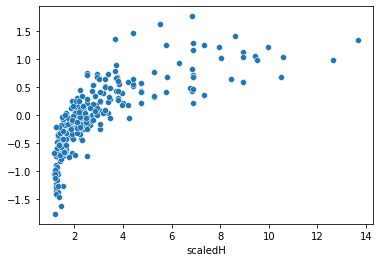

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


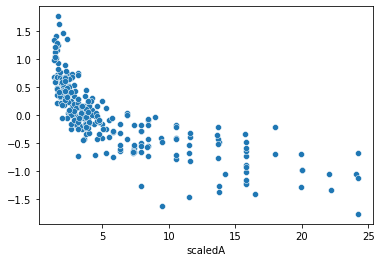

(0.7344469650712526, 0.9854163128214831, 1.0515184293767514)

In [ ]:
s = turn_to_seasons(years[0])
predict_matches(countries[0], s[0], s[1])

[[1.         0.74001954]
 [0.74001954 1.        ]]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


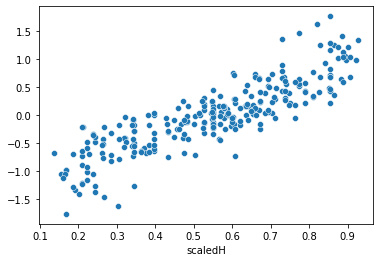

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


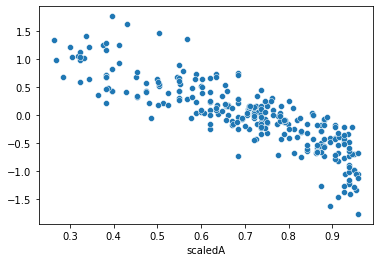

(0.7344469650712526, 0.9854163128214831, 1.0515184293767514)

In [ ]:
s = turn_to_seasons(years[0])
predict_matches(countries[0], s[0], s[1])

[[1.         0.06381727]
 [0.06381727 1.        ]]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


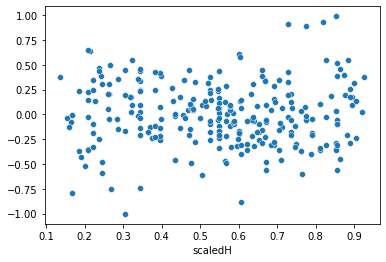

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


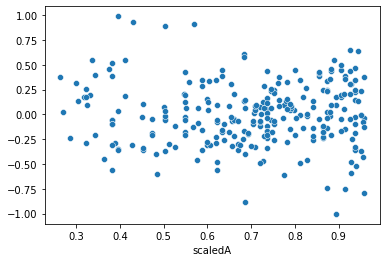

(0.7344469650712526, 0.9854163128214831, 1.0515184293767514)

In [ ]:
s = turn_to_seasons(years[0])
predict_matches(countries[0], s[0], s[1])

### Model 1 vs 2

In [ ]:
def prob_bad(home_team, away_team, c, df_teams):
  x1 = df_teams[df_teams['team'] == home_team]["goals_scored"].iloc[0]
  x2 = df_teams[df_teams['team'] == away_team]["goals_scored"].iloc[0]
  x3 = df_teams[df_teams['team'] == home_team]["goals_recieved"].iloc[0]
  x4 = df_teams[df_teams['team'] == away_team]["goals_recieved"].iloc[0]

  goals_h = x1 * c[0] + x2 * c[1] + x3 * c[2] + x4 * c[3] + \
            np.power(x1,2) * c[4] + np.power(x2,2) * c[5] + \
            np.power(x3,2) * c[6] + np.power(x4,2) * c[7]
  goals_a = x1 * c[1] + x2 * c[0] + x3 * c[3] + x4 * c[2] + \
            np.power(x1,2) * c[5] + np.power(x2,2) * c[4] + \
            np.power(x3,2) * c[7] + np.power(x4,2) * c[6]

  prob_h = 0
  prob_d = 0
  prob_a = 0

  if goals_h <= 0:
    goals_h = 0.1

  if goals_a <= 0:
    goals_a = 0.1

  if goals_h > 9.9:
    goals_h = 9.9

  if goals_a > 9.9:
    goals_a = 9.9

  sv_h = goals_h * 0
  sv_a = goals_a * 0

  pois_home = []
  pois_away = []
  for i in range(10):
    x_h = 2*precomp_p(i, goals_h)
    if goals_h - sv_h > 0:
      x_h += precomp_p(i, goals_h - sv_h)
    if goals_h + sv_h > 0:
      x_h += precomp_p(i, goals_h + sv_h)
    x_h /= 4
    x_a = 2*precomp_p(i, goals_a)
    if goals_a - sv_a > 0:
      x_a += precomp_p(i, goals_a - sv_a)
    if goals_a + sv_a > 0:
      x_a += precomp_p(i, goals_a + sv_a)
    x_a /= 4
    pois_home.append(x_h)
    pois_away.append(x_a)

  for i in range(10):
    for j in range(10):
      prob_ij = pois_home[i] * pois_away[j]
      if i > j:
        prob_h += prob_ij
      if i == j:
        prob_d += prob_ij
      if i < j:
        prob_a += prob_ij

  virtual = prob_h + prob_d + prob_a

  return (prob_h/virtual, prob_d/virtual, prob_a/virtual)

In [ ]:
def predict_matches(country, season_data, season_test):
  df = pd.read_sql_query(f"SELECT home_team_api_id, \
                        away_team_api_id, \
                        possession, \
                        home_team_goal, \
                        away_team_goal, \
                        B365H, \
                        B365D, \
                        B365A, \
                        date, \
                        season \
                        FROM Match \
                        WHERE B365H IS NOT NULL \
                        AND league_id == {country} \
                        ORDER BY date ASC", connection)

  df["scaledH"], df["scaledD"], df["scaledA"] = scaleodds([df['B365H'], df['B365D'], df['B365A']])
  df["result"] = result([df['home_team_goal'], df['away_team_goal']])

  df_data = df[df["season"] == season_data]
  df_test = df[df["season"] == season_test]


  n_bins = 3

  teams1 = df_test['home_team_api_id'].unique()

  teams2 = df_data['home_team_api_id'].unique()

  teams = pd.Series(list(set(teams1) & set(teams2)))

  df_teams = pd.DataFrame({"team":teams})

  df_data = remove_not_in_teams(df_data, teams)

  df_test = remove_not_in_teams(df_test, teams)


  df_teams["goals_scored"], df_teams["goals_recieved"] = aggregate_goals(df_data, teams)

  df_data["x1"] = df_data.apply(lambda x: compute_x1(x.home_team_api_id, df_teams), axis=1)
  df_data["x2"] = df_data.apply(lambda x: compute_x2(x.away_team_api_id, df_teams), axis=1)
  df_data["x3"] = df_data.apply(lambda x: compute_x3(x.home_team_api_id, df_teams), axis=1)
  df_data["x4"] = df_data.apply(lambda x: compute_x4(x.away_team_api_id, df_teams), axis=1)

  df_test["x1"] = df_test.apply(lambda x: compute_x1(x.home_team_api_id, df_teams), axis=1)
  df_test["x2"] = df_test.apply(lambda x: compute_x2(x.away_team_api_id, df_teams), axis=1)
  df_test["x3"] = df_test.apply(lambda x: compute_x3(x.home_team_api_id, df_teams), axis=1)
  df_test["x4"] = df_test.apply(lambda x: compute_x4(x.away_team_api_id, df_teams), axis=1)

  df_data_r = df_data.copy()

  df_data_r["x2"] = df_data["x1"]
  df_data_r["x1"] = df_data["x2"]
  df_data_r["x3"] = df_data["x4"]
  df_data_r["x4"] = df_data["x3"]
  df_data_r["home_team_goal"] = df_data["away_team_goal"]
  df_data_r["scaledH"] = df_data["scaledA"]

  df_data_r = pd.concat([df_data, df_data_r])

  X = np.array([df_data_r["x1"]*df_data_r["x4"]])
  y = np.array(df_data_r["home_team_goal"])
  X = X.T
  reg = LinearRegression().fit(X, y)

  c =  reg.coef_

  X = np.array([df_data_r["x1"], df_data_r["x2"], df_data_r["x3"], df_data_r["x4"],
              df_data_r["x1"]*df_data_r["x1"], df_data_r["x2"]*df_data_r["x2"],
              df_data_r["x3"]*df_data_r["x3"], df_data_r["x4"]*df_data_r["x4"],
              ])
  y = np.array(df_data_r["scaledH"])
  X = X.T
  reg = LinearRegression().fit(X, y)

  c_bad = reg.coef_

  confidences_and_draw = df_test.apply(lambda x: confidence(x.home_team_api_id,
                                x.away_team_api_id,
                                c, c_bad, df_teams), axis=1)

  confs = []
  for x in confidences_and_draw:
    confs.append(list(x))

  confs = np.array(confs).T

  #print(np.corrcoef(confs[1], df_test["scaledH"]))
  #sns.scatterplot(1-1/df_test["scaledH"], confs[1])
  #plt.show()
  #sns.scatterplot(1-1/df_test["scaledA"], confs[1])
  #plt.show()

  X = np.array([1-1/df_test["scaledH"]])
  X = X.T

  y = np.array(confs[1])

  reg = LinearRegression().fit(X, y)

  confs2 = y - reg.predict(X)

  #print(np.corrcoef(confs2, df_test["scaledH"]))
  #sns.scatterplot(1-1/df_test["scaledH"], confs2)
  #plt.show()
  #sns.scatterplot(1-1/df_test["scaledA"], confs2)
  #plt.show()

  df_test["confidence"] = np.absolute(confs2)
  df_test["sign_conf"] = np.sign(confs2)

  df_test["bin"] = pd.qcut(df_test["confidence"], q=[0, 0.333, 0.667, 1], labels=list(range(3)))

  df_test["bet"] = decision4(df_test['sign_conf'])

  b0_t, _ = wins(df_test[df_test['bin'] == 0]["bet"], df_test[df_test['bin'] == 0])
  b1_t, _ = wins(df_test[df_test['bin'] == 1]["bet"], df_test[df_test['bin'] == 1])
  b2_t, _ = wins(df_test[df_test['bin'] == 2]["bet"], df_test[df_test['bin'] == 2])

  return b0_t, b1_t, b2_t

[[1.         0.73534841]
 [0.73534841 1.        ]]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


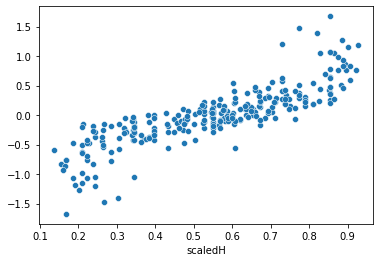

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


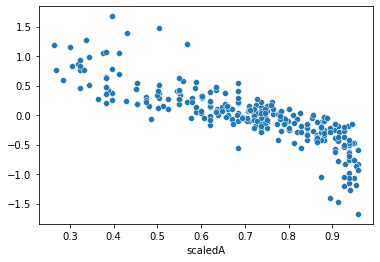

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[[1.         0.08315498]
 [0.08315498 1.        ]]


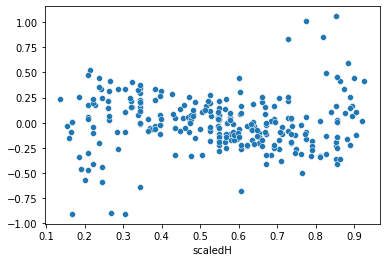

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


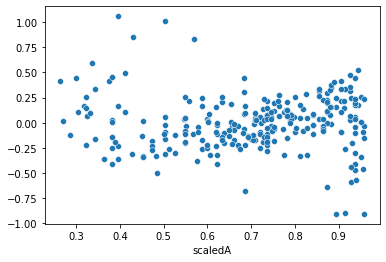

(0.9380439615461672, 1.0751436575391489, 0.7496931194493751)

In [ ]:
s = turn_to_seasons(years[0])
predict_matches(countries[0], s[0], s[1])

### Testing Model 1 vs 2

In [ ]:
wins_list = []
for year in years[:-3]:
  s = turn_to_seasons(year)

  wins_this_year = []
  for c in countries:
    w1, w2, w3 = predict_matches(c, s[0], s[1])
    wins_this_year.append([w1, w2, w3])

  wins_list.append(wins_this_year)
  print("----------------------")

----------------------
----------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


----------------------
----------------------
----------------------


In [ ]:
np.save("win_list8stupid.npy", wins_list)

In [ ]:
weights_list = []
year = 2008
for wins_this_year in wins_list:
  wins_this_year = np.array(wins_this_year)
  if year == 2008:
    mius1, lfs1 = expected_returns0(wins_this_year[:, 0], 0.005)
    mius2, lfs2 = expected_returns0(wins_this_year[:, 1], 0.01)
    mius3, lfs3 = expected_returns0(wins_this_year[:, 2], 0.015)
    lfs = [lfs1, lfs2, lfs3]
  else:
    mius1, lfs1 = expected_returns(wins_this_year[:, 0], lfs1)
    mius2, lfs2 = expected_returns(wins_this_year[:, 1], lfs2)
    mius3, lfs3 = expected_returns(wins_this_year[:, 2], lfs3)
    lfs = [lfs1, lfs2, lfs3]

  if year == 2008:
    print("profit: 1")
  else:
    print("profit:", profit(np.array(weights), wins_this_year.flatten()))

  weights = get_weights(mius1+mius2+mius3, std)
  weights_list.append(weights)

  year += 1

profit: 1
profit: 0.9551901810225657
profit: 1.0276735917966766
profit: 0.998835092579719
profit: 1.0126507730967662


In [ ]:
wins_list

In [ ]:
std = np.array(wins_list).flatten().std()

In [ ]:
wl = np.array(wins_list)[-1].flatten().mean()

1.0275366367478214

In [ ]:
examples = []
for _ in range(1000):
  example = np.array(choices(wl, k=wl.size))
  examples.append(example.mean())

In [ ]:
examples = np.array(examples)

In [ ]:
examples.std()

0.015201385852022508

### Model 2 vs 1

In [ ]:
def prob_bad(home_team, away_team, c, df_teams):
  #c1 = c[0]
  #c2 = c[1]

  goals_h = df_teams[df_teams['team'] == home_team]["goals_scored"].iloc[0] + \
          df_teams[df_teams['team'] == away_team]["goals_recieved"].iloc[0]
  goals_a = df_teams[df_teams['team'] == away_team]["goals_scored"].iloc[0] + \
          df_teams[df_teams['team'] == home_team]["goals_recieved"].iloc[0]

  goals_h /= 2
  goals_a /= 2

  prob_h = 0
  prob_d = 0
  prob_a = 0

  pois_home = []
  pois_away = []
  for i in range(10):
    x_h = 2*precomp_p(i, goals_h)
    if goals_h > 0:
      x_h += precomp_p(i, goals_h)
    if goals_h > 0:
      x_h += precomp_p(i, goals_h)
    x_h /= 4
    x_a = 2*precomp_p(i, goals_a)
    if goals_a > 0:
      x_a += precomp_p(i, goals_a)
    if goals_a > 0:
      x_a += precomp_p(i, goals_a)
    x_a /= 4
    pois_home.append(x_h)
    pois_away.append(x_a)

  for i in range(10):
    for j in range(10):
      prob_ij = pois_home[i] * pois_away[j]
      if i > j:
        prob_h += prob_ij
      if i == j:
        prob_d += prob_ij
      if i < j:
        prob_a += prob_ij

  prob_h += np.power(prob_h, 2)
  prob_a += np.power(prob_a, 2)
  virtual = prob_h + prob_d + prob_a

  return (prob_h/virtual, prob_d/virtual, prob_a/virtual)

In [ ]:
def probabilities(home_team, away_team, c, df_teams):
  x1 = df_teams[df_teams['team'] == home_team]["goals_scored"].iloc[0]
  x2 = df_teams[df_teams['team'] == away_team]["goals_scored"].iloc[0]
  x3 = df_teams[df_teams['team'] == home_team]["goals_recieved"].iloc[0]
  x4 = df_teams[df_teams['team'] == away_team]["goals_recieved"].iloc[0]

  goals_h = x1 * c[0] + x2 * c[1] + x3 * c[2] + x4 * c[3] + \
            np.power(x1,2) * c[4] + np.power(x2,2) * c[5] + \
            np.power(x3,2) * c[6] + np.power(x4,2) * c[7]
  goals_a = x1 * c[1] + x2 * c[0] + x3 * c[3] + x4 * c[2] + \
            np.power(x1,2) * c[5] + np.power(x2,2) * c[4] + \
            np.power(x3,2) * c[7] + np.power(x4,2) * c[6]

  prob_h = 0
  prob_d = 0
  prob_a = 0

  if goals_h <= 0:
    goals_h = 0.1

  if goals_a <= 0:
    goals_a = 0.1

  if goals_h > 9.9:
    goals_h = 9.9

  if goals_a > 9.9:
    goals_a = 9.9

  sv_h = 1 / goals_h * 0.3
  sv_a = 1 / goals_a * 0.3

  pois_home = []
  pois_away = []
  for i in range(10):
    x_h = 2*precomp_p(i, goals_h)
    if goals_h - sv_h > 0:
      x_h += precomp_p(i, goals_h - sv_h)
    if goals_h + sv_h > 0:
      x_h += precomp_p(i, goals_h + sv_h)
    x_h /= 4
    x_a = 2*precomp_p(i, goals_a)
    if goals_a - sv_a > 0:
      x_a += precomp_p(i, goals_a - sv_a)
    if goals_a + sv_a > 0:
      x_a += precomp_p(i, goals_a + sv_a)
    x_a /= 4
    pois_home.append(x_h)
    pois_away.append(x_a)

  for i in range(10):
    for j in range(10):
      prob_ij = pois_home[i] * pois_away[j]
      if i > j:
        prob_h += prob_ij
      if i == j:
        prob_d += prob_ij
      if i < j:
        prob_a += prob_ij

  virtual = prob_h + prob_d + prob_a

  return (prob_h/virtual, prob_d/virtual, prob_a/virtual)

In [ ]:
def predict_matches(country, season_data, season_test):
  df = pd.read_sql_query(f"SELECT home_team_api_id, \
                        away_team_api_id, \
                        possession, \
                        home_team_goal, \
                        away_team_goal, \
                        B365H, \
                        B365D, \
                        B365A, \
                        date, \
                        season \
                        FROM Match \
                        WHERE B365H IS NOT NULL \
                        AND league_id == {country} \
                        ORDER BY date ASC", connection)

  df["scaledH"], df["scaledD"], df["scaledA"] = scaleodds([df['B365H'], df['B365D'], df['B365A']])
  df["result"] = result([df['home_team_goal'], df['away_team_goal']])

  df_data = df[df["season"] == season_data]
  df_test = df[df["season"] == season_test]


  n_bins = 3

  teams1 = df_test['home_team_api_id'].unique()

  teams2 = df_data['home_team_api_id'].unique()

  teams = pd.Series(list(set(teams1) & set(teams2)))

  df_teams = pd.DataFrame({"team":teams})

  df_data = remove_not_in_teams(df_data, teams)

  df_test = remove_not_in_teams(df_test, teams)


  df_teams["goals_scored"], df_teams["goals_recieved"] = aggregate_goals(df_data, teams)

  df_data["x1"] = df_data.apply(lambda x: compute_x1(x.home_team_api_id, df_teams), axis=1)
  df_data["x2"] = df_data.apply(lambda x: compute_x2(x.away_team_api_id, df_teams), axis=1)
  df_data["x3"] = df_data.apply(lambda x: compute_x3(x.home_team_api_id, df_teams), axis=1)
  df_data["x4"] = df_data.apply(lambda x: compute_x4(x.away_team_api_id, df_teams), axis=1)

  df_test["x1"] = df_test.apply(lambda x: compute_x1(x.home_team_api_id, df_teams), axis=1)
  df_test["x2"] = df_test.apply(lambda x: compute_x2(x.away_team_api_id, df_teams), axis=1)
  df_test["x3"] = df_test.apply(lambda x: compute_x3(x.home_team_api_id, df_teams), axis=1)
  df_test["x4"] = df_test.apply(lambda x: compute_x4(x.away_team_api_id, df_teams), axis=1)

  df_data_r = df_data.copy()

  df_data_r["x2"] = df_data["x1"]
  df_data_r["x1"] = df_data["x2"]
  df_data_r["x3"] = df_data["x4"]
  df_data_r["x4"] = df_data["x3"]
  df_data_r["home_team_goal"] = df_data["away_team_goal"]
  df_data_r["scaledH"] = df_data["scaledA"]

  df_data_r = pd.concat([df_data, df_data_r])

  X = np.array([df_data_r["x1"], df_data_r["x2"], df_data_r["x3"], df_data_r["x4"],
                df_data_r["x1"]*df_data_r["x1"], df_data_r["x2"]*df_data_r["x2"],
                df_data_r["x3"]*df_data_r["x3"], df_data_r["x4"]*df_data_r["x4"],
                ])
  y = np.array(df_data_r["home_team_goal"])
  X = X.T
  reg = LinearRegression().fit(X, y)

  c = reg.coef_

  c_bad = []

  confidences_and_draw = df_test.apply(lambda x: confidence(x.home_team_api_id,
                                x.away_team_api_id,
                                c, c_bad, df_teams), axis=1)

  confs = []
  for x in confidences_and_draw:
    confs.append(list(x))

  confs = np.array(confs).T

  #print(np.corrcoef(confs[1], df_test["scaledH"]))
  #sns.scatterplot(1-1/df_test["scaledH"], confs[1])
  #plt.show()
  #sns.scatterplot(1-1/df_test["scaledA"], confs[1])
  #plt.show()

  X = np.array([1-1/df_test["scaledH"]])
  X = X.T

  y = np.array(confs[1])

  reg = LinearRegression().fit(X, y)

  confs2 = y - reg.predict(X)

  #print(np.corrcoef(confs2, df_test["scaledH"]))
  #sns.scatterplot(1-1/df_test["scaledH"], confs2)
  #plt.show()
  #sns.scatterplot(1-1/df_test["scaledA"], confs2)
  #plt.show()

  df_test["confidence"] = np.absolute(confs2)
  df_test["sign_conf"] = np.sign(confs2)

  df_test["bin"] = pd.qcut(df_test["confidence"], q=[0, 0.333, 0.667, 1], labels=list(range(3)))

  df_test["bet"] = decision4(df_test['sign_conf'])

  b0_t, _ = wins(df_test[df_test['bin'] == 0]["bet"], df_test[df_test['bin'] == 0])
  b1_t, _ = wins(df_test[df_test['bin'] == 1]["bet"], df_test[df_test['bin'] == 1])
  b2_t, _ = wins(df_test[df_test['bin'] == 2]["bet"], df_test[df_test['bin'] == 2])

  return b0_t, b1_t, b2_t

### Testing Model 2 vs 1

In [ ]:
wins_list = []
for year in years[:-3]:
  s = turn_to_seasons(year)

  wins_this_year = []
  for c in countries:
    w1, w2, w3 = predict_matches(c, s[0], s[1])
    wins_this_year.append([w1, w2, w3])

  wins_list.append(wins_this_year)
  print("----------------------")

----------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

----------------------
----------------------
----------------------
----------------------


In [ ]:
np.save("win_list8stupid.npy", wins_list)

In [ ]:
weights_list = []
year = 2008
for wins_this_year in wins_list:
  wins_this_year = np.array(wins_this_year)
  if year == 2008:
    mius1, lfs1 = expected_returns0(wins_this_year[:, 0], 0.005)
    mius2, lfs2 = expected_returns0(wins_this_year[:, 1], 0.01)
    mius3, lfs3 = expected_returns0(wins_this_year[:, 2], 0.015)
    lfs = [lfs1, lfs2, lfs3]
  else:
    mius1, lfs1 = expected_returns(wins_this_year[:, 0], lfs1)
    mius2, lfs2 = expected_returns(wins_this_year[:, 1], lfs2)
    mius3, lfs3 = expected_returns(wins_this_year[:, 2], lfs3)
    lfs = [lfs1, lfs2, lfs3]

  if year == 2008:
    print("profit: 1")
  else:
    print("profit:", profit(np.array(weights), wins_this_year.flatten()))

  weights = get_weights(mius1+mius2+mius3, std)
  weights_list.append(weights)

  year += 1

profit: 1
profit: 0.9775709376096456
profit: 0.9720057770251876
profit: 0.965278424106519
profit: 1.0189355880770377


In [ ]:
wins_list

In [ ]:
std = np.array(wins_list).flatten().std()

In [ ]:
wl = np.array(wins_list)[-1].flatten().mean()

In [ ]:
examples = []
for _ in range(1000):
  example = np.array(choices(wl, k=wl.size))
  examples.append(example.mean())

In [ ]:
examples = np.array(examples)

In [ ]:
examples.std()

### Model 1 vs 1 final test

In [ ]:
def probabilities(home_team, away_team, c, df_teams):
  goals_h = df_teams[df_teams['team'] == home_team]["goals_scored"].iloc[0] * \
          df_teams[df_teams['team'] == away_team]["goals_recieved"].iloc[0]
  goals_a = df_teams[df_teams['team'] == away_team]["goals_scored"].iloc[0] * \
          df_teams[df_teams['team'] == home_team]["goals_recieved"].iloc[0]

  goals_h *= c[0]
  goals_a *= c[0]

  prob_h = 0
  prob_d = 0
  prob_a = 0

  pois_home = []
  pois_away = []
  for i in range(10):
    x_h = 2*precomp_p(i, goals_h)
    if goals_h > 0:
      x_h += precomp_p(i, goals_h)
    if goals_h > 0:
      x_h += precomp_p(i, goals_h)
    x_h /= 4
    x_a = 2*precomp_p(i, goals_a)
    if goals_a > 0:
      x_a += precomp_p(i, goals_a)
    if goals_a > 0:
      x_a += precomp_p(i, goals_a)
    x_a /= 4
    pois_home.append(x_h)
    pois_away.append(x_a)

  for i in range(10):
    for j in range(10):
      prob_ij = pois_home[i] * pois_away[j]
      if i > j:
        prob_h += prob_ij
      if i == j:
        prob_d += prob_ij
      if i < j:
        prob_a += prob_ij

  virtual = prob_h + prob_d + prob_a

  return (prob_h/virtual, prob_d/virtual, prob_a/virtual)

In [ ]:
def prob_bad(home_team, away_team, c, df_teams):
  #c1 = c[0]
  #c2 = c[1]

  goals_h = df_teams[df_teams['team'] == home_team]["goals_scored"].iloc[0] + \
          df_teams[df_teams['team'] == away_team]["goals_recieved"].iloc[0]
  goals_a = df_teams[df_teams['team'] == away_team]["goals_scored"].iloc[0] + \
          df_teams[df_teams['team'] == home_team]["goals_recieved"].iloc[0]

  goals_h /= 2
  goals_a /= 2

  prob_h = 0
  prob_d = 0
  prob_a = 0

  pois_home = []
  pois_away = []
  for i in range(10):
    x_h = 2*precomp_p(i, goals_h)
    if goals_h > 0:
      x_h += precomp_p(i, goals_h)
    if goals_h > 0:
      x_h += precomp_p(i, goals_h)
    x_h /= 4
    x_a = 2*precomp_p(i, goals_a)
    if goals_a > 0:
      x_a += precomp_p(i, goals_a)
    if goals_a > 0:
      x_a += precomp_p(i, goals_a)
    x_a /= 4
    pois_home.append(x_h)
    pois_away.append(x_a)

  for i in range(10):
    for j in range(10):
      prob_ij = pois_home[i] * pois_away[j]
      if i > j:
        prob_h += prob_ij
      if i == j:
        prob_d += prob_ij
      if i < j:
        prob_a += prob_ij

  prob_h += np.power(prob_h, 2)
  prob_a += np.power(prob_a, 2)
  virtual = prob_h + prob_d + prob_a

  return (prob_h/virtual, prob_d/virtual, prob_a/virtual)

In [ ]:
def predict_matches(country, season_data, season_test):
  df = pd.read_sql_query(f"SELECT home_team_api_id, \
                        away_team_api_id, \
                        possession, \
                        home_team_goal, \
                        away_team_goal, \
                        B365H, \
                        B365D, \
                        B365A, \
                        date, \
                        season \
                        FROM Match \
                        WHERE B365H IS NOT NULL \
                        AND league_id == {country} \
                        ORDER BY date ASC", connection)

  df["scaledH"], df["scaledD"], df["scaledA"] = scaleodds([df['B365H'], df['B365D'], df['B365A']])
  df["result"] = result([df['home_team_goal'], df['away_team_goal']])

  df_data = df[df["season"] == season_data]
  df_test = df[df["season"] == season_test]



  n_bins = 3

  teams1 = df_test['home_team_api_id'].unique()

  teams2 = df_data['home_team_api_id'].unique()

  teams = pd.Series(list(set(teams1) & set(teams2)))

  df_teams = pd.DataFrame({"team":teams})

  df_data = remove_not_in_teams(df_data, teams)

  df_test = remove_not_in_teams(df_test, teams)


  df_teams["goals_scored"], df_teams["goals_recieved"] = aggregate_goals(df_data, teams)

  df_data["x1"] = df_data.apply(lambda x: compute_x1(x.home_team_api_id, df_teams), axis=1)
  df_data["x2"] = df_data.apply(lambda x: compute_x2(x.away_team_api_id, df_teams), axis=1)
  df_data["x3"] = df_data.apply(lambda x: compute_x3(x.home_team_api_id, df_teams), axis=1)
  df_data["x4"] = df_data.apply(lambda x: compute_x4(x.away_team_api_id, df_teams), axis=1)

  df_test["x1"] = df_test.apply(lambda x: compute_x1(x.home_team_api_id, df_teams), axis=1)
  df_test["x2"] = df_test.apply(lambda x: compute_x2(x.away_team_api_id, df_teams), axis=1)
  df_test["x3"] = df_test.apply(lambda x: compute_x3(x.home_team_api_id, df_teams), axis=1)
  df_test["x4"] = df_test.apply(lambda x: compute_x4(x.away_team_api_id, df_teams), axis=1)

  df_data_r = df_data.copy()

  df_data_r["x2"] = df_data["x1"]
  df_data_r["x1"] = df_data["x2"]
  df_data_r["x3"] = df_data["x4"]
  df_data_r["x4"] = df_data["x3"]
  df_data_r["home_team_goal"] = df_data["away_team_goal"]
  df_data_r["scaledH"] = df_data["scaledA"]

  df_data_r = pd.concat([df_data, df_data_r])

  X = np.array([df_data_r["x1"]*df_data_r["x4"]])
  y = np.array(df_data_r["home_team_goal"])
  X = X.T
  reg = LinearRegression().fit(X, y)

  c =  reg.coef_

  c_bad = []

  confidences_and_draw = df_test.apply(lambda x: confidence(x.home_team_api_id,
                                x.away_team_api_id,
                                c, c_bad, df_teams), axis=1)

  confs = []
  for x in confidences_and_draw:
    confs.append(list(x))

  confs = np.array(confs).T

  #print(np.corrcoef(confs[1], df_test["scaledH"]))
  #sns.scatterplot(1-1/df_test["scaledH"], confs[1])
  #plt.show()
  #sns.scatterplot(1-1/df_test["scaledA"], confs[1])
  #plt.show()

  X = np.array([1-1/df_test["scaledH"]])
  X = X.T

  y = np.array(confs[1])

  reg = LinearRegression().fit(X, y)

  confs2 = y - reg.predict(X)

  #print(np.corrcoef(confs2, df_test["scaledH"]))
  #sns.scatterplot(1-1/df_test["scaledH"], confs2)
  #plt.show()
  #sns.scatterplot(1-1/df_test["scaledA"], confs2)
  #plt.show()

  df_test["confidence"] = np.absolute(confs2)
  df_test["sign_conf"] = np.sign(confs2)

  df_test["bin"] = pd.qcut(df_test["confidence"], q=[0, 0.333, 0.667, 1], labels=list(range(3)))

  df_test["bet"] = decision4(df_test['sign_conf'])

  b0_t, _ = wins(df_test[df_test['bin'] == 0]["bet"], df_test[df_test['bin'] == 0])
  b1_t, _ = wins(df_test[df_test['bin'] == 1]["bet"], df_test[df_test['bin'] == 1])
  b2_t, _ = wins(df_test[df_test['bin'] == 2]["bet"], df_test[df_test['bin'] == 2])

  return b0_t, b1_t, b2_t

In [ ]:
wins_list = []
for year in years[:-1]:
  s = turn_to_seasons(year)

  wins_this_year = []
  for c in countries:
    w1, w2, w3 = predict_matches(c, s[0], s[1])
    wins_this_year.append([w1, w2, w3])

  wins_list.append(wins_this_year)
  print("----------------------")

----------------------
----------------------
----------------------
----------------------
----------------------
----------------------
----------------------


In [ ]:
wins_list

[[[1.0107340207339925, 0.975076880472445, 0.7681617808744697],
  [1.4919930643217805, 1.1634040157971066, 1.1678609988047528],
  [0.9158821452115345, 1.0610868200166041, 0.9347511896536193],
  [0.8656418093850354, 0.6575779467115574, 0.5999851026896647],
  [0.8821925349414801, 0.9477909796928766, 0.8392093748535367],
  [1.112171388277386, 1.0725866266278832, 0.7392076972148796],
  [0.8470521240000608, 1.1100252981838428, 0.852540724463762],
  [1.133494378024459, 1.0668249491326327, 0.6634814489258891]],
 [[0.4423405415400036, 1.0469928046622503, 1.4107684239035398],
  [0.9467615802449451, 0.9177457173453938, 0.9284850322920589],
  [1.1903764697602703, 1.1061471794426518, 0.9707015368333698],
  [1.0549366382941956, 0.7554907534984499, 1.1305177425225648],
  [0.7675904622040781, 1.2552767645141087, 0.8574250872727303],
  [0.8388627904227314, 0.8710658687035396, 1.2506441931629972],
  [0.9204312644606181, 1.3634373197793197, 0.5535777936444357],
  [0.8405375894102014, 1.391421317725285, 0

In [ ]:
np.save("win_list_test_final.npy", wins_list)

In [ ]:
std = 0.12

### Profit

In [ ]:
fee = 0

In [ ]:
weights_list = []
year = 2008
for wins_this_year in wins_list:
  wins_this_year = np.array(wins_this_year)
  if year == 2008:
    mius1, lfs1 = expected_returns0(wins_this_year[:, 0], 0.005)
    mius2, lfs2 = expected_returns0(wins_this_year[:, 1], 0.01)
    mius3, lfs3 = expected_returns0(wins_this_year[:, 2], 0.015)
    lfs = [lfs1, lfs2, lfs3]
  else:
    mius1, lfs1 = expected_returns(wins_this_year[:, 0], lfs1)
    mius2, lfs2 = expected_returns(wins_this_year[:, 1], lfs2)
    mius3, lfs3 = expected_returns(wins_this_year[:, 2], lfs3)
    lfs = [lfs1, lfs2, lfs3]

  if year == 2008:
    print("profit: 1")
  else:
    print("profit:", profit(np.array(weights), wins_this_year.flatten()))

  weights = get_weights(mius1+mius2+mius3, std)
  weights_list.append(weights)

  year += 1

profit: 1
profit: 0.9833291911057271
profit: 1.024936570826446
profit: 1.0539085675045208
profit: 1.0188021801898288
profit: 1.0661727726406054
profit: 1.0454064584340952


In [ ]:
wins_list2 = np.array(wins_list)[-2:]
weights_list2 = np.array(weights_list)[-2:]

In [ ]:
wil_flat = wins_list2.flatten()
wel_flat = weights_list2.flatten()

In [ ]:
bootstraped_results = []
for _ in range(10000):
  indexes = choices(range(wil_flat.size), k=wil_flat.size)
  bootstraped_list = wil_flat[indexes]*wel_flat[indexes]
  bootstraped_results.append(bootstraped_list.sum()/wel_flat[indexes].sum())

In [ ]:
bootstraped_results = np.array(bootstraped_results)

In [ ]:
conf_i = np.quantile(bootstraped_results,[0.05, 0.95])

$H_0$(null hypothesis): No significant deviation from 0% return on investment(ROI) (excluding the fee)
<br>
$H_1$(alternative hypothesis): ROI higher than 0% (excluding the fee)

In [ ]:
print(f'single-tailed p-value: {(bootstraped_results <= 1.0).mean() * 100:.2f}%')

single-tailed p-value: 2.84%


In [ ]:
print(f'90% Confidence Interval: ({(conf_i[0]-1)*100:.2f}%,{(conf_i[1]-1)*100:.2f}%) ROI (excluding the fee)')

90% Confidence Interval: (0.77%,9.50%) ROI (excluding the fee)


In [ ]:
print(f'True 90% CI: ({(conf_i[0]-1.042)*100:.2f}%,{(conf_i[1]-1.042)*100:.2f}%) ROI (including the fee)')

True 90% CI: (-3.43%,5.30%) ROI (including the fee)


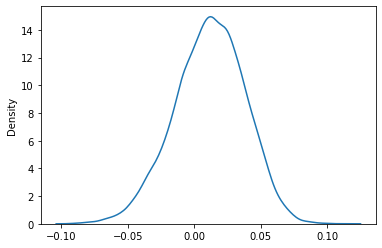

In [ ]:
sns.kdeplot(bootstraped_results-1-0.042);

In [ ]:
wel = np.array(weights_list)[-1]
wil = (np.array(wins_list)[-1].flatten()-1) * wel

In [ ]:
wel_countries = wel[::3] + wel[1::3] + wel[2::3]
wil_countries = wil[::3] + wil[1::3] + wil[2::3]

In [ ]:
wel_bins = sum([wel[i::8] for i in range(8)], np.array([0,0,0]))
wil_bins = sum([wil[i::8] for i in range(8)], np.array([0,0,0]))

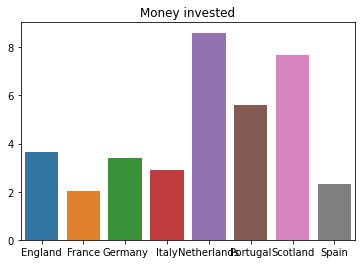

In [ ]:
sns.barplot(x=countries_names, y=wel_countries).set(title="Money invested");

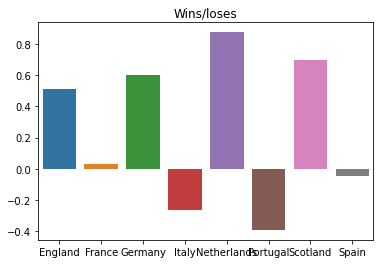

In [ ]:
sns.barplot(x=countries_names, y=wil_countries).set(title="Wins/loses");

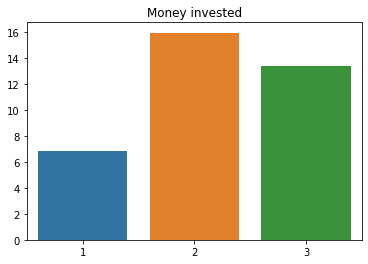

In [ ]:
sns.barplot(x=list(range(1, 4)), y=wel_bins).set(title="Money invested");

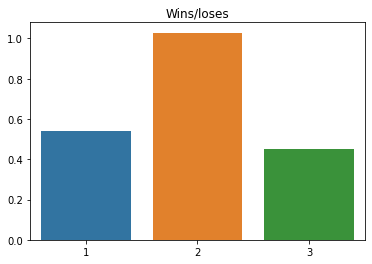

In [ ]:
sns.barplot(x=list(range(1, 4)), y=wil_bins).set(title="Wins/loses");

### Real profit

In [ ]:
fee = 0.042

In [ ]:
def combine2(u1, u2, v1, v2):
  u1 -= fee
  u2 -= fee
  def to_maximize(x):
    return (x*x*u1*u1+(1-x)*(1-x)*u2*u2+(1-x)*x*u1*u2)/(x*x*v1+(1-x)*(1-x)*v2)
  weightings_returns = []
  xses = np.linspace(0.01, 0.99, 1001)
  for x in xses:
    weightings_returns.append(to_maximize(x))
  w1 = xses[np.array(weightings_returns).argmax()]
  w2 = 1 - w1
  miu_new = w1 * u1 + w2 * u2
  var_new = w1*w1 * v1 + w2*w2 * v2
  return miu_new, var_new, w2/w1

In [ ]:
def get_weights2(new_mius, std):
  weights = [1 for i in range(len(new_mius))]
  k = len(new_mius)
  for j in range(len(new_mius)):
    p_miu, p_var = new_mius[j], std*std
    if p_miu <= fee:
      weights[j] = 0
    else:
      k = j+1
      break

  scale = 1

  for i in range(k, len(new_mius)):
    if new_mius[i] > fee:
      p_miu, p_var, rat = combine2(p_miu, new_mius[i], p_var, std*std)
      weights[i] = rat * scale
      scale += weights[i]
    else:
      weights[i] = 0

  return weights

In [ ]:
def get_weights3(new_mius, std):
  weights = [1 for i in range(len(new_mius))]
  k = len(new_mius)
  for j in range(len(new_mius)):
    p_miu, p_var = new_mius[j], std*std
    if p_miu <= fee:
      weights[j] = 0
    else:
      k = j+1
      break

  scale = 1

  for i in range(k, len(new_mius)):
    if new_mius[i] > fee:
      weights[i] = 1
    else:
      weights[i] = 0

  return weights

In [ ]:
weights_list = []
year = 2008
for wins_this_year in wins_list:
  wins_this_year = np.array(wins_this_year)
  if year == 2008:
    mius1, lfs1 = expected_returns0(wins_this_year[:, 0], 0.05)
    mius2, lfs2 = expected_returns0(wins_this_year[:, 1], 0.05)
    mius3, lfs3 = expected_returns0(wins_this_year[:, 2], 0.05)
    lfs = [lfs1, lfs2, lfs3]
  else:
    mius1, lfs1 = expected_returns(wins_this_year[:, 0], lfs1)
    mius2, lfs2 = expected_returns(wins_this_year[:, 1], lfs2)
    mius3, lfs3 = expected_returns(wins_this_year[:, 2], lfs3)
    lfs = [lfs1, lfs2, lfs3]

  if year == 2008:
    print("profit: 1")
  else:
    print("profit:", profit(np.array(weights), wins_this_year.flatten()-fee))

  weights = get_weights2(mius1+mius2+mius3, std)
  weights_list.append(weights)

  year += 1

profit: 1
profit: 1.0098408609437926
profit: 1.0728722106194877
profit: 1.2392858423985045
profit: 1.1391713706420898
profit: 1.0540707624366368
profit: 0.9831975211172479


In [ ]:
wins_list2 = np.array(wins_list)[-2:]
weights_list2 = np.array(weights_list)[-2:]

In [ ]:
wil_flat = wins_list2.flatten()
wel_flat = weights_list2.flatten()

In [ ]:
bootstraped_results = []
for _ in range(10000):
  indexes = choices(range(wil_flat.size), k=wil_flat.size)
  bootstraped_list = wil_flat[indexes]*wel_flat[indexes]
  bootstraped_results.append(bootstraped_list.sum()/wel_flat[indexes].sum())

In [ ]:
bootstraped_results = np.array(bootstraped_results)

In [ ]:
conf_i = np.quantile(bootstraped_results,[0.05, 0.95])

In [ ]:
wel = np.array(weights_list)[-1]
wil = (np.array(wins_list)[-1].flatten()-1) * wel

In [ ]:
wel_countries = wel[::3] + wel[1::3] + wel[2::3]
wil_countries = wil[::3] + wil[1::3] + wil[2::3]

In [ ]:
wel_bins = sum([wel[i::8] for i in range(8)], np.array([0,0,0]))
wil_bins = sum([wil[i::8] for i in range(8)], np.array([0,0,0]))

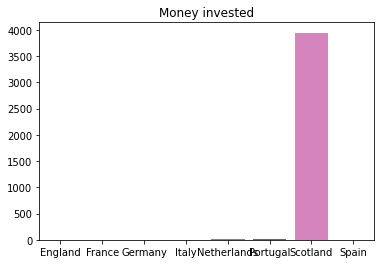

In [ ]:
sns.barplot(x=countries_names, y=wel_countries).set(title="Money invested");

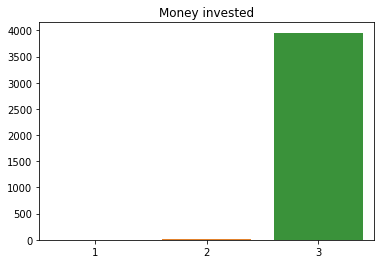

In [ ]:
sns.barplot(x=list(range(1, 4)), y=wel_bins).set(title="Money invested");

### Real profit more spread

In [ ]:
fee = 0.042

In [ ]:
def get_weights3(new_mius, std):
  weights = [1 for i in range(len(new_mius))]
  k = len(new_mius)
  for j in range(len(new_mius)):
    p_miu, p_var = new_mius[j], std*std
    if p_miu <= fee:
      weights[j] = 0
    else:
      k = j+1
      break

  scale = 1

  for i in range(k, len(new_mius)):
    if new_mius[i] > fee:
      weights[i] = 1
    else:
      weights[i] = 0

  return weights

In [ ]:
weights_list = []
year = 2008
for wins_this_year in wins_list:
  wins_this_year = np.array(wins_this_year)
  if year == 2008:
    mius1, lfs1 = expected_returns0(wins_this_year[:, 0], 0.05)
    mius2, lfs2 = expected_returns0(wins_this_year[:, 1], 0.05)
    mius3, lfs3 = expected_returns0(wins_this_year[:, 2], 0.05)
    lfs = [lfs1, lfs2, lfs3]
  else:
    mius1, lfs1 = expected_returns(wins_this_year[:, 0], lfs1)
    mius2, lfs2 = expected_returns(wins_this_year[:, 1], lfs2)
    mius3, lfs3 = expected_returns(wins_this_year[:, 2], lfs3)
    lfs = [lfs1, lfs2, lfs3]

  if year == 2008:
    print("profit: 1")
  else:
    print("profit:", profit(np.array(weights), wins_this_year.flatten()-fee))

  weights = get_weights3(mius1+mius2+mius3, std)
  weights_list.append(weights)

  year += 1

profit: 1
profit: 0.9684734715069082
profit: 0.990280037393779
profit: 1.0870884739431557
profit: 1.0523098168440501
profit: 1.0278832485710288
profit: 1.0382770564759634


In [ ]:
wins_list2 = np.array(wins_list)[-2:]
weights_list2 = np.array(weights_list)[-2:]

In [ ]:
wil_flat = wins_list2.flatten()
wel_flat = weights_list2.flatten()

In [ ]:
bootstraped_results = []
for _ in range(10000):
  indexes = choices(range(wil_flat.size), k=wil_flat.size)
  bootstraped_list = wil_flat[indexes]*wel_flat[indexes]
  bootstraped_results.append(bootstraped_list.sum()/wel_flat[indexes].sum())

In [ ]:
bootstraped_results = np.array(bootstraped_results)

In [ ]:
conf_i = np.quantile(bootstraped_results,[0.05, 0.95])

In [ ]:
wel = np.array(weights_list)[-1]
wil = (np.array(wins_list)[-1].flatten()-1) * wel

In [ ]:
wel_countries = wel[::3] + wel[1::3] + wel[2::3]
wil_countries = wil[::3] + wil[1::3] + wil[2::3]

In [ ]:
wel_bins = sum([wel[i::8] for i in range(8)], np.array([0,0,0]))
wil_bins = sum([wil[i::8] for i in range(8)], np.array([0,0,0]))

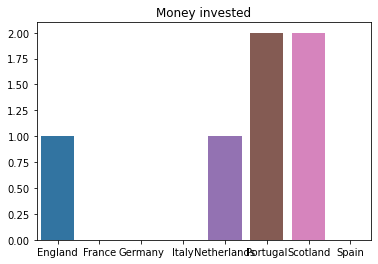

In [ ]:
sns.barplot(x=countries_names, y=wel_countries).set(title="Money invested");

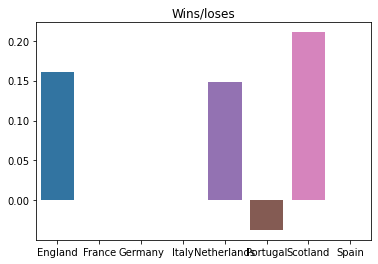

In [ ]:
sns.barplot(x=countries_names, y=wil_countries).set(title="Wins/loses");

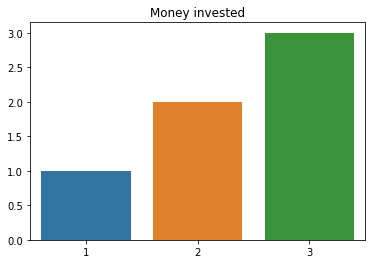

In [ ]:
sns.barplot(x=list(range(1, 4)), y=wel_bins).set(title="Money invested");

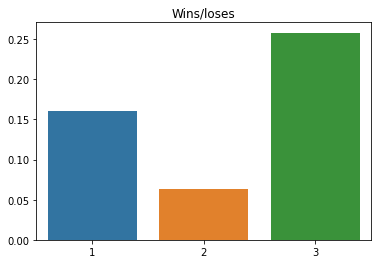

In [ ]:
sns.barplot(x=list(range(1, 4)), y=wil_bins).set(title="Wins/loses");